# Multimessenger, proper sampling

## The Problem

We have huge flux of neutrinos arriving at the detector every second with different energies. <br>
By convolving the flux with the cross-section and integrating over all neutrino energies we can get the differential interaction rates per time and per recoil energy accurately. <br>

Further integrating this over either time or recoil energies, we can also get the "total expected interactions". <br>

Now, when we want to sample these interactions, it gets a bit tricky. In the past, we were sampling from the integrated rates individually and matching them at random. This although gives the correct times and correct recoil energies individually, we lose the information of different energy distributions at different times.

In [2]:
import numpy as np
import astropy.units as u
from tqdm.notebook import tqdm
from snewpy.neutrino import Flavor
from multimessenger.supernova import Supernova_Models
import matplotlib.pyplot as plt
plt.style.use('customstyle.mplstyle')
from matplotlib.colors import LogNorm
from scipy.integrate import quad
from scipy.interpolate import interp1d
from snewpy.neutrino import Flavor
from multimessenger.supernova.Nucleus import Target
from multimessenger.supernova.Xenon_Atom import ATOM_TABLE
from multimessenger.supernova.interactions import Interactions

In [3]:
SN_Nakazato = Supernova_Models.Models("Nakazato_2013", config_file="./local_conf.conf")
SN_Nakazato(index=5) # brings the attributes

> Nakazato_2013 is created, load a progenitor by function call.
> You chose ~wisely~ ->	   [5]	nakazato-shen-z0.004-t_rev200ms-s13.0.fits
>>>>> Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits.pickle
> Retrieving object self.storageNakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits.pickle


/mnt/c/Users/bj7780/Desktop/Kara/GitHub/XENON/multimessenger/multimessenger/supernova/snewpy_models.py:85: FutureWarning: Initializing this model with a filename is deprecated. Instead, use keyword arguments ['progenitor_mass', 'revival_time', 'metallicity', 'eos']. See `Nakazato_2013.param`, `Nakazato_2013.get_param_combinations()` for more info.
  models_dict[self.name](f)
/mnt/c/Users/bj7780/Desktop/Kara/GitHub/XENON/multimessenger/multimessenger/supernova/snewpy_models.py:66: FutureWarning: Initializing this model with a filename is deprecated. Instead, use keyword arguments ['progenitor_mass', 'revival_time', 'metallicity', 'eos']. See `Nakazato_2013.param`, `Nakazato_2013.get_param_combinations()` for more info.
  model = models_dict[self.name](file_to_load, **model_kwargs)


> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits_interaction.pickle!



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

> Computed the total rates at the source for 1 atom (not scaled)


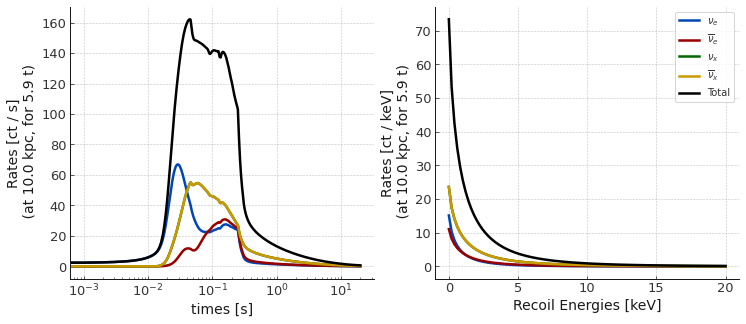

In [4]:
Int = Interactions(SN_Nakazato)
Int.compute_interaction_rates()
Int.scale_rates(10, 5.9);
Int.plot_rates(scaled=True)

Have a look at the **neutrino energy distributions** at a given time $t=t_0$. 

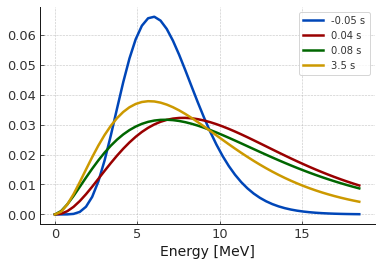

In [13]:
some_index = [0, 50, 100, 300]
for i in some_index:
    flux = Int.Model.fluxes[Flavor.NU_E][i,:50]
    plt.plot(Int.Model.neutrino_energies[:50], flux/np.sum(flux), label=Int.Model.times[i])
plt.xlabel('Energy [MeV]')
plt.legend();

The first approach then would be to sampling a time first, and then at a given time sampling a neutrino energy based on these distributions, however, you will end up with very low neutrino energies. Then if you go ahead and sample a recoil energy from the cross-section of $E_\nu - E_{R}$ that recoil will also be low or even zero. <br>

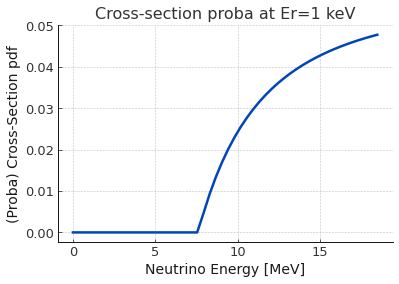

In [11]:
# cross-section for 1 keV interactions with all neutrino energies
crs = Int.Nucleus[0].nN_cross_section(Int.Model.neutrino_energies[:50], np.array([1])*u.keV)
plt.plot(Int.Model.neutrino_energies[:50], crs[0]/np.sum(crs[0]))
plt.xlabel("Neutrino Energy [MeV]")
plt.ylabel('(Proba) Cross-Section pdf');
plt.title('Cross-section proba at Er=1 keV');

As one can see, to get a 1 keV recoil, you need at least ~8 MeV neutrinos, therefore, when we sample a neutrino energy at a given time, if we sample 3-4 MeV neutrinos, it is already guaranteed that these neutrinos **will not interact**. And since we are sampling the interactions and not all of the flux, we should take this into account, and sample only the relavant neutrino energy spectrum.

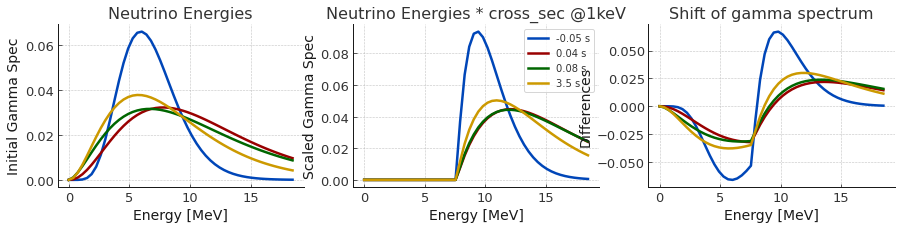

In [15]:
fig, (ax1,ax2, ax3) = plt.subplots(ncols=3, figsize=(15,3))
for i in some_index:
    flux = Int.Model.fluxes[Flavor.NU_E][i,:50]
    ax1.plot(Int.Model.neutrino_energies[:50], flux/np.sum(flux))
    ax2.plot(Int.Model.neutrino_energies[:50], (flux*crs[0])/np.sum(flux*crs[0]), label=Int.Model.times[i])
    ax3.plot(Int.Model.neutrino_energies[:50], (flux*crs[0])/np.sum(flux*crs[0]) - flux/np.sum(flux), label=Int.Model.times[i])

ax1.set_title('Neutrino Energies')
ax2.set_title('Neutrino Energies * cross_sec @1keV')
ax3.set_title('Shift of gamma spectrum')
ax1.set_xlabel('Energy [MeV]'); ax2.set_xlabel('Energy [MeV]'); ax3.set_xlabel('Energy [MeV]')
ax1.set_ylabel("Initial Gamma Spec"); ax2.set_ylabel("Scaled Gamma Spec")
ax3.set_ylabel("Differences")
ax2.legend();

So, convolving with the cross-section shifts the "expected neutrino energy distribution that can interact" to the higher neutrino energies. Now, when you sample neutrinos from this distribution, an interaction is guaranteed. 

We can also look at these in 2D, if we select a time $t=t_0$ and take the initial neutrino energy spectrum, and convolve it with the cross-section at every neutrino energy for each recoil energy. We can get a probability map. 

/tmp/ipykernel_435/1917535092.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = axes[i].pcolormesh((flux_t0*crosssec)/np.sum(flux_t0*crosssec), cmap='PuBu', norm=LogNorm(1e-6,0.01))


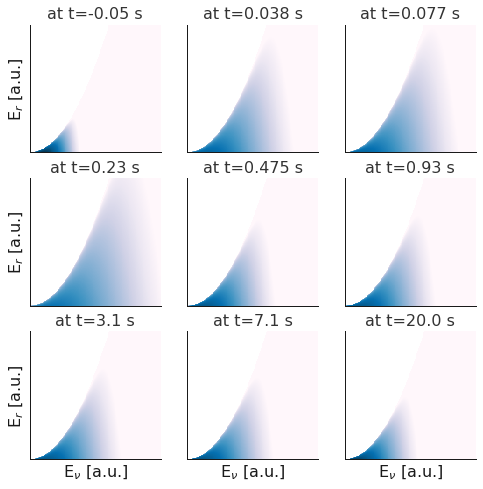

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
axes = axes.ravel()
crosssec = Int.Nucleus[0].nN_cross_section(Int.Model.neutrino_energies[:150], np.linspace(0,20,250)*u.keV)
_ttime = Int.Model.times.value

for i, idxt0 in enumerate(np.linspace(0, len(_ttime)-1, 9, dtype=int)):
    flux_t0 = Int.Model.fluxes[Flavor.NU_E][idxt0,:150] 
    cb = axes[i].pcolormesh((flux_t0*crosssec)/np.sum(flux_t0*crosssec), cmap='PuBu', norm=LogNorm(1e-6,0.01)) 
    axes[i].set_title(f'at t={Int.Model.times[idxt0]}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
for i in range(3):
    axes = axes.reshape(3,3)
    axes[-1,i].set_xlabel(r'E$_\nu$ [a.u.]', fontsize=16)
    axes[i,0].set_ylabel(r'E$_r$ [a.u.]', fontsize=16);
# plt.colorbar(cb);

These maps also clearly shows the regions where you don't have any cross-section (upper left parts), and where you don't have any flux at that energies (right parts). <br>
So, these can be interpreted as the interaction probability maps at each time.

## Toy MC

Now let's run some toy monte carlo and compare the results. 

In [23]:
def _inverse_transform_sampling(x_vals, y_vals, n_samples):
    cum_values = np.zeros(x_vals.shape)
    y_mid = (y_vals[1:] + y_vals[:-1]) * 0.5
    cum_values[1:] = np.cumsum(y_mid * np.diff(x_vals))
    inv_cdf = interp1d(cum_values / np.max(cum_values), x_vals)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

In order to sample times, we can use the differential rates as a function of time, these rates are integrated over neutrino and recoil energies. This doesn't pose any problem here, as we will sample these again from their original distributions according to the recipe above.

In [25]:
Model = Int.Model
times = Model.times.value
totrates = Int.rates_per_time_scaled[Flavor.NU_E]

Now, we can run a toy-MC. <br>
We first sample times for `N_interaction` and use these same times for all toy-MCs. <br>
At each of these `N_interaction` time steps, we sample `Nmc` neutrino energies from the modified gamma spectrum at the sampled time step. <br> 
And at each of those neutrino energies we sample a recoil energy based on the cross-section.<br>

Therefore we should end up with `Nmc` times sampled recoil energies for each time step. <br>
We can concatanate them to look at total expected recoil spectrum over all times, and we can also study the recoil spectra shapes at different times.

In [66]:
flavor = Flavor.NU_E
NEUTRINO_ENERGIES = np.linspace(0, 150, 500)
RECOIL_ENERGIES = np.linspace(0, 20, 100)

def sampled_distributions(N_interaction=120, Nmc=1000):
    """
    N_interaction = 120     # number of interactions for each "event sample"
    Nmc = 1000              # number of event samples i.e. number of toy MC
    """
    # sample times from integrated time-spectrum
    sampled_times = _inverse_transform_sampling(times, totrates, N_interaction)
    sampled_times = np.sort(sampled_times)

    ############### Fluxes at the sampled times, convolved with the cross-sections
    fluxes_at_times = Int.Model.model.get_initial_spectra(t=sampled_times*u.s, 
                                                          E=NEUTRINO_ENERGIES*u.MeV, 
                                                          flavors=[flavor])[flavor]

    crosssec = Int.Nucleus[0].nN_cross_section(NEUTRINO_ENERGIES*u.MeV,
                                               RECOIL_ENERGIES*u.keV)

    flux_xsec = np.zeros((len(sampled_times), len(RECOIL_ENERGIES), len(NEUTRINO_ENERGIES)))
    for i, t in enumerate(sampled_times):
        flux_xsec[i] = (fluxes_at_times[i,:]*crosssec)/np.sum(fluxes_at_times[i,:]*crosssec)
    ###############

    if Nmc == 1:
        sampled_nues, sampled_recoils = np.zeros(len(sampled_times)), np.zeros(len(sampled_times))
        for i, t in tqdm(enumerate(sampled_times), total=len(sampled_times), desc=flavor.name):
            bb = np.trapz(flux_xsec[i], axis=0)
            sampled_nues[i] = _inverse_transform_sampling(NEUTRINO_ENERGIES, bb, 1)
            recspec = Int.Nucleus[0].nN_cross_section(sampled_nues[i] * u.MeV, RECOIL_ENERGIES * u.keV).value.flatten()
            sampled_recoils[i] = _inverse_transform_sampling(RECOIL_ENERGIES, recspec / np.sum(recspec), 1)[0]
    else:
        sampled_nues, sampled_recoils = np.zeros((len(sampled_times), Nmc)), np.zeros((len(sampled_times), Nmc))
        for i, t in tqdm(enumerate(sampled_times), total=len(sampled_times), desc=flavor.name):
            bb = np.trapz(flux_xsec[i], axis=0)
            sampled_nues[i] = _inverse_transform_sampling(NEUTRINO_ENERGIES, bb, Nmc)
            recspec = Int.Nucleus[0].nN_cross_section(sampled_nues[i] * u.MeV, RECOIL_ENERGIES * u.keV).value
            for j in range(Nmc):
                sampled_recoils[i,j] = _inverse_transform_sampling(RECOIL_ENERGIES, recspec[:,j]/np.sum(recspec[:,j]), 1)
    return sampled_times, sampled_recoils, sampled_nues

In [72]:
def plot_distributions(sampled_times, sampled_recoils, sampled_nues):
    cuts = np.linspace(0,len(sampled_times)-1,5,dtype=int)

    fig, (ax1,ax2, ax3) = plt.subplots(ncols=3, figsize=(17,3))
    for i in range(0,5):
        if np.ndim(sampled_recoils)==1:
            ax1.hist(sampled_nues[cuts[i]], bins=10, histtype='step', lw=1.5, label=f"{sampled_times[cuts[i]]:.2f}");
            ax2.hist(sampled_recoils[cuts[i]], bins=10, histtype='step', lw=1.5, label=f"{sampled_times[cuts[i]]:.2f}");
        else:
            ax1.hist(sampled_nues[cuts[i],:], bins=100, histtype='step', lw=1.5, label=f"{sampled_times[cuts[i]]:.2f}");
            ax2.hist(sampled_recoils[cuts[i],:], bins=100, histtype='step', lw=1.5, label=f"{sampled_times[cuts[i]]:.2f}");


    ax3.hist(sampled_recoils.flatten(), bins=100, histtype='step', lw=1.5, density=True, label='total sample');
    ax3.plot(Int.recoil_energies[Int.recoil_energies.value<10], 
             (Int.rates_per_recoil_scaled['Total']/np.sum(Int.rates_per_recoil_scaled['Total']))[Int.recoil_energies.value<10]*5,
             label='pdf (scaled)')
    ax3.legend()

    ax2.set_xlim(-0.5,10); ax3.set_xlim(-0.5,10)
    ax2.legend();
    ax1.set_xlabel("Sampled Nu Energies")
    ax2.set_xlabel("Sampled Recoil Energies")
    ax3.set_xlabel("Total Sampled Recoil");

NU_E:   0%|          | 0/120 [00:00<?, ?it/s]

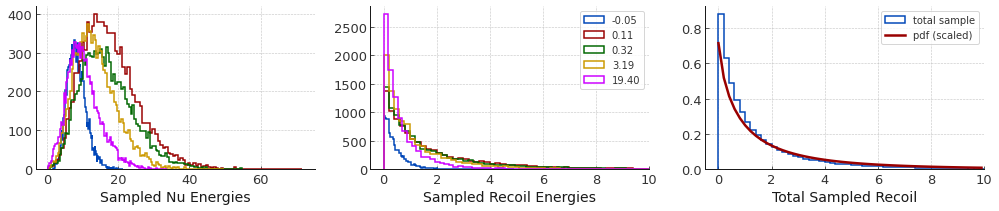

In [73]:
a,b,c = sampled_distributions(N_interaction=120, Nmc=10000)
plot_distributions(a,b,c)

Or if one want to sample just 1 occurance, we can set the `Nmc=1`

NU_E:   0%|          | 0/120 [00:00<?, ?it/s]

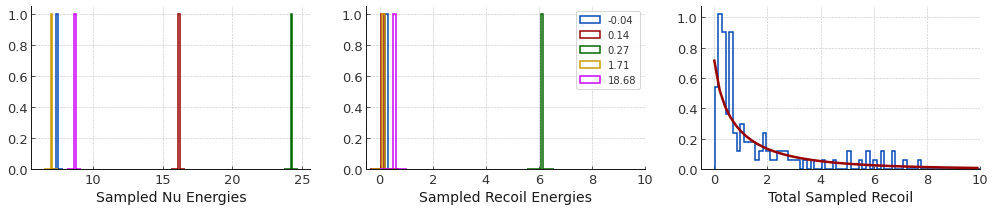

In [68]:
aa,bb,cc = sampled_distributions(N_interaction=120, Nmc=1)
plot_distributions(aa,bb,cc)

The `multimessenger` package computes the total expected counts for each neutrino flavor. Then, samples that many interactions for each flavor and combines them. It further selects the isotope with the highest abundance to calculate cross-section rates. (Ideally, the isotopes could also be sampled based on their abundances, however, it is not expected to have a major effect on the outcome).